In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=3

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=3


In [4]:
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir
from avgn.tensorflow.data import _parse_function

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/te

In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
%matplotlib inline
from IPython import display
import pandas as pd

# the nightly build of tensorflow_probability is required as of the time of writing this 
import tensorflow_probability as tfp
ds = tfp.distributions

In [6]:
print(tf.__version__, tfp.__version__)

2.0.0-beta1 0.7.0-dev20190510


In [7]:
TRAIN_SIZE=101726
BATCH_SIZE=128
TEST_SIZE=10000
DIMS = (128, 128, 1)
N_TRAIN_BATCHES =int((TRAIN_SIZE-TEST_SIZE)/BATCH_SIZE)
N_TEST_BATCHES = int(TEST_SIZE/BATCH_SIZE)
TRAIN_BUF = 1000
TEST_BUF = 1000

In [8]:
record_loc = DATA_DIR / 'tfrecords' / "starling.tfrecords"

In [9]:
# read the dataset
raw_dataset = tf.data.TFRecordDataset([record_loc.as_posix()])

In [10]:
data_types = {
    "spectrogram": tf.uint8,
    "index": tf.int64,
    "indv": tf.string,
}

In [11]:
# parse each data type to the raw dataset
dataset = raw_dataset.map(lambda x: _parse_function(x, data_types=data_types))

In [12]:
spec, index, indv  = next(iter(dataset))

Text(0.5, 1.05, 'Spectrogram')

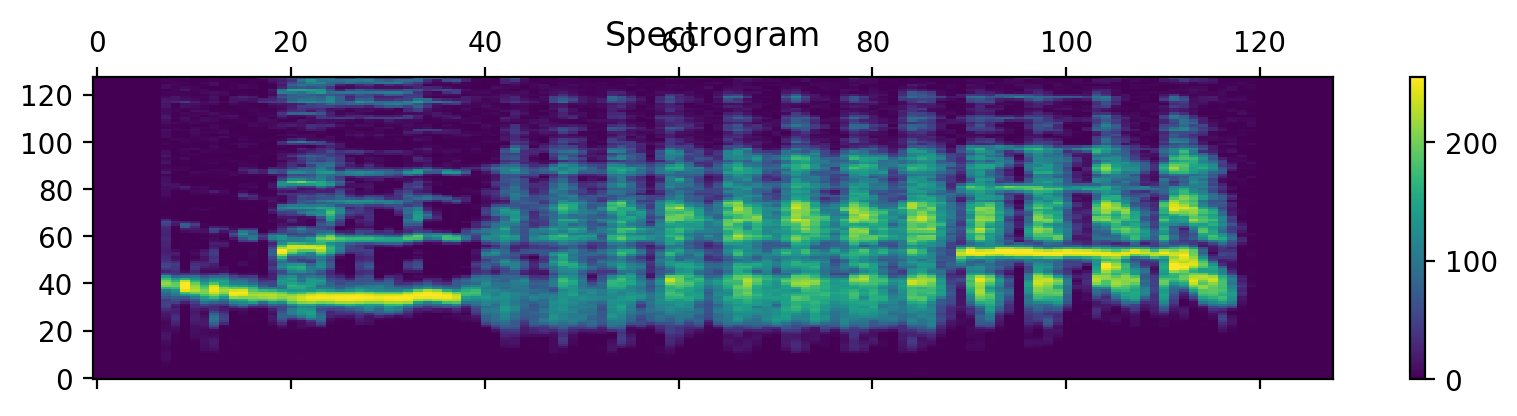

In [13]:
fig, ax = plt.subplots(dpi=200, figsize=(10,2))
im = ax.matshow(spec.numpy().reshape((128,128)), origin="lower", aspect="auto")
fig.colorbar(im)
plt.title('Spectrogram')

### try reconstruction

In [14]:
from avgn.signalprocessing.spectrogramming import (
    spectrogram, melspectrogram, inv_spectrogram, _build_mel_basis,
    _build_mel_inversion_basis, spectrogram_librosa, inv_spectrogram_librosa, _mel_to_linear)
from avgn.utils.hparams import HParams
from IPython.display import display, Audio

In [15]:
hparams = HParams(
    num_mels = 128,
    mel_lower_edge_hertz=500,
    mel_upper_edge_hertz=20000,
    butter_lowcut = 500,
    butter_highcut = 20000,
    ref_level_db = 20,
    min_level_db = -45,
    mask_spec = True,
    win_length_ms = 10,
    hop_length_ms = 2,
    nex=-1,
    n_jobs=-1,
    verbosity = 1,
)

In [16]:
rate = 44100

In [17]:
_mel_basis = _build_mel_basis(hparams, rate, rate)
_mel_inversion_basis = _build_mel_inversion_basis(_mel_basis)

In [18]:
rescale_factor = 0.23
from PIL import Image

def resize_spec(spec, scaling_factor=10):
    resize_shape = [int(np.shape(spec)[1] / scaling_factor), np.shape(spec)[0]]
    resize_spec = np.array(Image.fromarray(spec).resize(resize_shape, Image.ANTIALIAS))
    return resize_spec

In [19]:
melspec = spec.numpy().reshape(128,128)
melspec = resize_spec(melspec, scaling_factor=rescale_factor) / 256
mel_inv_spec = _mel_to_linear(melspec, _mel_inverse_basis = _mel_inversion_basis)

0.9960937796859071 0.0


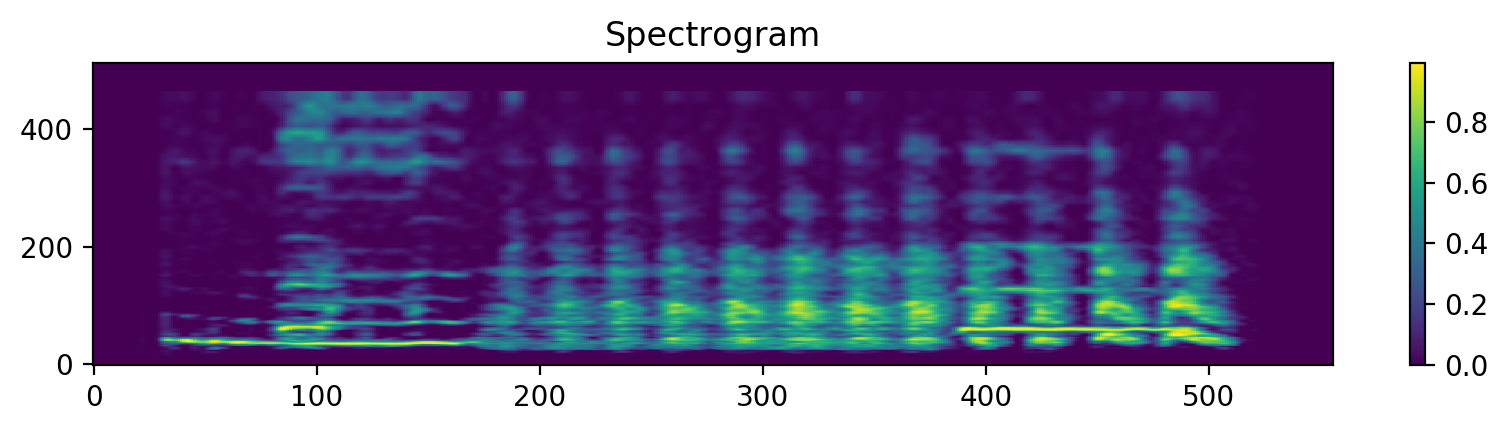

In [20]:
fig = plt.figure(dpi=200, figsize=(10,2))
im = plt.imshow(mel_inv_spec, origin="lower", aspect="auto")
fig.colorbar(im)
plt.title('Spectrogram')
print(np.max(mel_inv_spec), np.min(mel_inv_spec))

In [21]:
signal_mel_inv = inv_spectrogram_librosa(mel_inv_spec, rate, hparams)

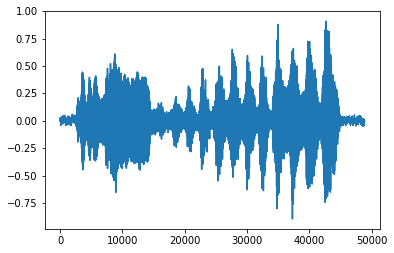

In [22]:
plt.plot(signal_mel_inv)

In [23]:
len(signal_mel_inv)

48840

In [24]:
print(len(signal_mel_inv)/rate)

1.107482993197279


In [25]:
display(Audio(signal_mel_inv, rate=rate))

### prep network

In [26]:
test_dataset = dataset.take(TEST_SIZE).shuffle(TRAIN_BUF).batch(BATCH_SIZE)
train_dataset = dataset.skip(TEST_SIZE).take(TRAIN_SIZE-TEST_SIZE).shuffle(TEST_BUF).batch(BATCH_SIZE)

In [27]:
N_Z = 128

encoder = [
    tf.keras.layers.InputLayer(input_shape=DIMS),
    tf.keras.layers.Conv2D(
        filters=32, kernel_size=3, strides=(2, 2), activation=tf.nn.leaky_relu
    ),
    tf.keras.layers.Conv2D(
        filters=64, kernel_size=3, strides=(2, 2), activation=tf.nn.leaky_relu
    ),
    tf.keras.layers.Conv2D(
        filters=128, kernel_size=3, strides=(2, 2), activation=tf.nn.leaky_relu
    ),
    tf.keras.layers.Conv2D(
        filters=256, kernel_size=3, strides=(2, 2), activation=tf.nn.leaky_relu
    ),
    tf.keras.layers.Conv2D(
        filters=256, kernel_size=3, strides=(2, 2), activation=tf.nn.leaky_relu
    ),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=N_Z*2),
]

decoder = [
    tf.keras.layers.Dense(units=4 * 4 * 256, activation=tf.nn.leaky_relu),
    tf.keras.layers.Reshape(target_shape=(4, 4, 256)),
    tf.keras.layers.Conv2DTranspose(
        filters=256, kernel_size=3, strides=(2, 2), padding="SAME", activation=tf.nn.leaky_relu
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=256, kernel_size=3, strides=(2, 2), padding="SAME", activation=tf.nn.leaky_relu
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=128, kernel_size=3, strides=(2, 2), padding="SAME", activation=tf.nn.leaky_relu
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=64, kernel_size=3, strides=(2, 2), padding="SAME", activation=tf.nn.leaky_relu
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=32, kernel_size=3, strides=(2, 2), padding="SAME", activation=tf.nn.leaky_relu
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=1, kernel_size=3, strides=(1, 1), padding="SAME"
    ),
]

In [28]:
from avgn.tensorflow.VAE2 import VAE, plot_reconstruction

In [29]:
# the optimizer for the model
optimizer = tf.keras.optimizers.Adam(1e-4)
# train the model
model = VAE(
    enc = encoder,
    dec = decoder,
    optimizer = optimizer,
    beta = 1.0
)

In [30]:
# exampled data for plotting results
example_data = next(iter(test_dataset))
example_data = (
        tf.cast(tf.reshape(example_data[0], [BATCH_SIZE] + list(DIMS)), tf.float32)
        / 255
)

In [31]:
x= example_data
x_recon = model.reconstruct(x)

### Save model

In [32]:
epoch = 435
DATASET_ID = 'european_starling_gentner_segmented'
network_type = 'VAE'
save_loc = DATA_DIR / 'models' / network_type / (DATASET_ID + '_128')
ensure_dir(save_loc)

# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model shuold be saved to HDF5.
#model.save_weights((save_loc / (str(epoch).zfill(4))).as_posix()) 
model.load_weights((save_loc / (str(epoch).zfill(4))).as_posix()) 

# Recreate the exact same model, including its weights and the optimizer
#new_model = tf.keras.models.load_model('my_model.h5')

### Reconstruct endpoints

In [33]:
from avgn.visualization.projections import scatter_spec
from avgn.utils.general import save_fig
from avgn.utils.paths import FIGURE_DIR, ensure_dir
ensure_dir(FIGURE_DIR / 'networks' / 'starling128')

In [34]:
gen_func =  model.decode
interp_len = 5

In [35]:
dset_iter = iter(dataset)
x1 = np.reshape(next(dset_iter)[0] / 255, (1,128,128,1))
x2 = np.reshape(next(dset_iter)[0] / 255, (1,128,128,1))
x3 = np.reshape(next(dset_iter)[0] / 255, (1,128,128,1))
exdat = np.vstack([x1, x2, x3])

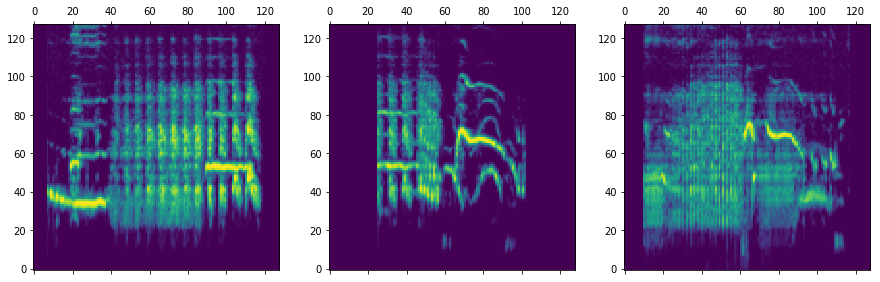

In [36]:
fig, axs = plt.subplots(ncols=3, figsize=(15,5))
axs[0].matshow(np.squeeze(x1), origin='lower')
axs[1].matshow(np.squeeze(x2), origin='lower')
axs[2].matshow(np.squeeze(x3), origin='lower')

In [37]:
melspec = x1.reshape(128,128)
melspec = resize_spec(melspec, scaling_factor=rescale_factor)
mel_inv_spec = _mel_to_linear(melspec, _mel_inverse_basis = _mel_inversion_basis)
signal_mel_inv = inv_spectrogram_librosa(mel_inv_spec, rate, hparams)
display(Audio(signal_mel_inv, rate=rate))

In [38]:
(pt1, pt2, pt3), _ = model.encode(exdat)

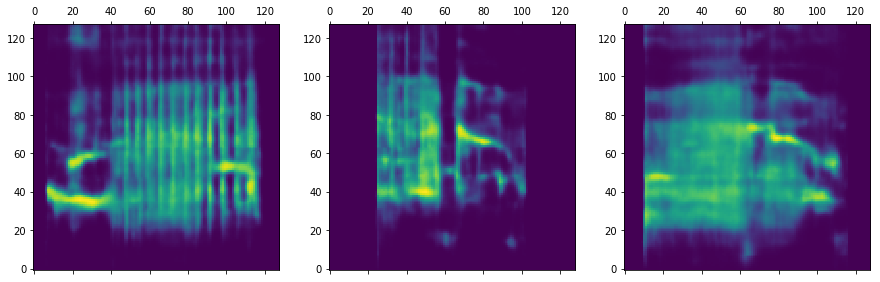

In [39]:
xr1, xr2, xr3 = model.decode(np.vstack([pt1, pt2, pt3]), apply_sigmoid=True)

fig, axs = plt.subplots(ncols=3, figsize=(15,5))
axs[0].matshow(np.squeeze(xr1.numpy()), origin='lower')
axs[1].matshow(np.squeeze(xr2.numpy()), origin='lower')
axs[2].matshow(np.squeeze(xr3.numpy()), origin='lower')

In [40]:
import noisereduce as nr

In [41]:
melspec = xr1.numpy().reshape(128,128)
melspec = resize_spec(melspec, scaling_factor=rescale_factor)
mel_inv_spec = _mel_to_linear(melspec, _mel_inverse_basis = _mel_inversion_basis)
signal_mel_inv = inv_spectrogram_librosa(mel_inv_spec, rate, hparams)
signal_mel_inv = nr.reduce_noise(signal_mel_inv, noise_clip=signal_mel_inv[:int(rate*.05)],n_std_thresh=2)
display(Audio(signal_mel_inv, rate=rate))

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]


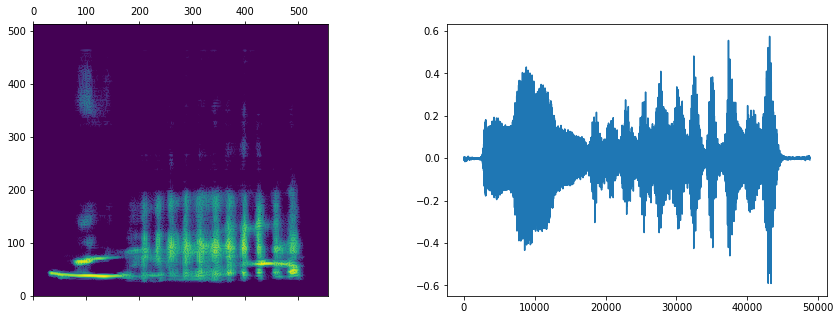

In [42]:
rec_spec = spectrogram_librosa(signal_mel_inv, rate, hparams)
fig, axs = plt.subplots(ncols=2, figsize=(15,5))
axs[0].matshow(np.squeeze(rec_spec), origin='lower')
axs[1].plot(signal_mel_inv)

### J Diagram

In [43]:
#pt1x,pt2x,pt3x =gen_func(tf.stack([pt1,pt2,pt3]))

#get proportions
z_list = []
for ci, C in enumerate(np.linspace(0, 1, interp_len)):
    for bi, B in enumerate(np.linspace(0, 1, interp_len)):
        A = 1 - C - B
        z_list.append(
            C * pt1 +
            B * pt2 + 
            A * pt3
        )
z_list = np.vstack(z_list)
# get X
x_list = gen_func(z_list, apply_sigmoid=True).numpy()

# make diagram
Jdiagram = np.ones((x_list.shape[1]*(interp_len), x_list.shape[2]*(interp_len+2), x_list.shape[3]))
np.shape(Jdiagram)

#populate
i = 0
for ci, C in enumerate(np.linspace(0, 1, interp_len)):
    for bi, B in enumerate(np.linspace(0, 1, interp_len)):
        Jdiagram[(interp_len -1 - bi)*x_list.shape[1]:((interp_len - bi))*x_list.shape[1], (ci+1)*x_list.shape[2]:(ci+2)*x_list.shape[2], :] = x_list[i]
        i+=1
Jdiagram[(interp_len - 1)*x_list.shape[1]: (interp_len)*x_list.shape[1], 
        :x_list.shape[2], :] = x3

Jdiagram[(interp_len - 1)*x_list.shape[1]: (interp_len)*x_list.shape[1], 
        (interp_len +1)*x_list.shape[2]: (interp_len+2)*x_list.shape[2] , :] = x1

Jdiagram[: x_list.shape[1], 
        :x_list.shape[2], :] = x2

(-0.5, 895.5, -0.5, 639.5)

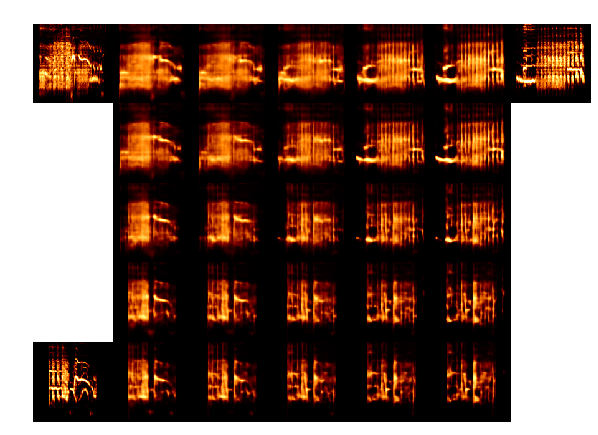

In [44]:
fig, ax = plt.subplots(figsize=(10,10))
ax.matshow(np.squeeze(Jdiagram), vmin = 0, cmap=plt.cm.afmhot, origin = 'lower')
ax.axis('off')
#save_fig(FIGURE_DIR / 'networks' / 'starling128'/ ('VAE_JDiagram_128'), dpi=300, save_jpg=True)

### interpolation GIF

In [108]:
z_list = []
n_frames = 50
for ii in np.linspace(0,1,n_frames):
    z_list.append(ii * pt2 + (1-ii) *pt1)
for ii in np.linspace(0,1,n_frames):
    z_list.append(ii * pt3 + (1-ii) *pt2)
for ii in np.linspace(0,1,n_frames):
    z_list.append(ii * pt1 + (1-ii) *pt3)
z_list = np.vstack(z_list)
# get X
x_list = gen_func(z_list, apply_sigmoid=True).numpy()
np.shape(x_list)

(150, 128, 128, 1)

In [109]:
from PIL import Image
x_list_rec_vae = []
for frame in tqdm(x_list):
    melspec = resize_spec(np.squeeze(frame), scaling_factor=rescale_factor)
    mel_inv_spec = _mel_to_linear(melspec, _mel_inverse_basis = _mel_inversion_basis)
    signal_mel_inv = inv_spectrogram_librosa(mel_inv_spec, rate, hparams)
    #signal_mel_inv = nr.reduce_noise(signal_mel_inv, noise_clip=signal_mel_inv[:int(rate*.05)],n_std_thresh=2)
    rec_spec = spectrogram_librosa(signal_mel_inv, rate, hparams)
    x_list_rec_vae.append(rec_spec)

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]


In [110]:
np.shape(x_list_rec_vae)

(150, 513, 556)

In [111]:
from matplotlib import animation, rc
from IPython.display import HTML, Image

In [112]:
# call the animator. blit=True means only re-draw the parts that 
# have changed.
# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots(figsize=(5,5))

im = ax.imshow(np.squeeze(x_list_rec_vae[0]), interpolation='none', aspect='auto',origin="lower", vmin = 0, cmap=plt.cm.afmhot)
ax.axis('off')
def init():
    im.set_data(np.squeeze(x_list_rec_vae[0]))
    return [im]

def animate_func(i):
    im.set_array(np.squeeze(x_list_rec_vae[i]))
    return [im]
    
anim = animation.FuncAnimation(
                               fig, 
                               animate_func, 
                               frames = n_frames*3,
                               interval = 50, # in ms
                               )

plt.close(anim._fig)
# Call function to display the animation
HTML(anim.to_html5_video())

#anim.save('../../files/animation.gif', writer='imagemagick', fps=60)

In [113]:
x_list = []
n_frames = 50
for ii in np.linspace(0,1,n_frames):
    x_list.append(ii * np.squeeze(x2) + (1-ii) *np.squeeze(x1))
for ii in np.linspace(0,1,n_frames):
    x_list.append(ii * np.squeeze(x3) + (1-ii) *np.squeeze(x2))
for ii in np.linspace(0,1,n_frames):
    x_list.append(ii * np.squeeze(x1) + (1-ii) *np.squeeze(x3))
x_list = np.array(x_list)
# get X
np.shape(x_list)

(150, 128, 128)

In [114]:
from PIL import Image
x_list_rec_lin = []
for frame in tqdm(x_list):
    melspec = resize_spec(np.squeeze(frame), scaling_factor=rescale_factor)
    mel_inv_spec = _mel_to_linear(melspec, _mel_inverse_basis = _mel_inversion_basis)
    signal_mel_inv = inv_spectrogram_librosa(mel_inv_spec, rate, hparams)
    #signal_mel_inv = nr.reduce_noise(signal_mel_inv, noise_clip=signal_mel_inv[:int(rate*.05)],n_std_thresh=2)
    rec_spec = spectrogram_librosa(signal_mel_inv, rate, hparams)
    x_list_rec_lin.append(rec_spec)

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]


In [115]:
# call the animator. blit=True means only re-draw the parts that 
# have changed.
# First set up the figure, the axis, and the plot element we want to animate
fig, axs = plt.subplots(ncols=2, figsize=(10,5))

im = axs[0].imshow(np.squeeze(x_list_rec_vae[0]), interpolation='none', aspect='auto',origin="lower", vmin = 0, cmap=plt.cm.afmhot)
im2 = axs[1].imshow(np.squeeze(x_list_rec_lin[0]), interpolation='none', aspect='auto',origin="lower", vmin = 0, cmap=plt.cm.afmhot)
axs[0].axis('off')
axs[1].axis('off')
def init():
    im.set_data(np.squeeze(x_list_rec_vae[0]))
    im2.set_data(np.squeeze(x_list_rec_lin[0]))
    return [im, im2]

def animate_func(i):
    im.set_array(np.squeeze(x_list_rec_vae[i]))
    im2.set_array(np.squeeze(x_list_rec_lin[i]))
    return [im, im2]
    
anim = animation.FuncAnimation(
                               fig, 
                               animate_func, 
                               frames = n_frames*3,
                               interval = 50, # in ms
                               )

plt.close(anim._fig)
# Call function to display the animation
HTML(anim.to_html5_video())

#anim.save('../../files/animation.gif', writer='imagemagick', fps=60)